In [1]:
%matplotlib widget

In [4]:
%load_ext autoreload
%autoreload 2

In [12]:
# from ipywidgets import *
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('TkAgg')
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

import mne
from mne import Epochs, compute_raw_covariance, io, pick_types, read_events
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image

from power import field_root_mean_square, plot_fmrs


In [13]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file /nethome/costamai/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [14]:
#choose channels
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 14 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [15]:
#not important - renaming
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

ValueError: Invalid RGBA argument: 're'

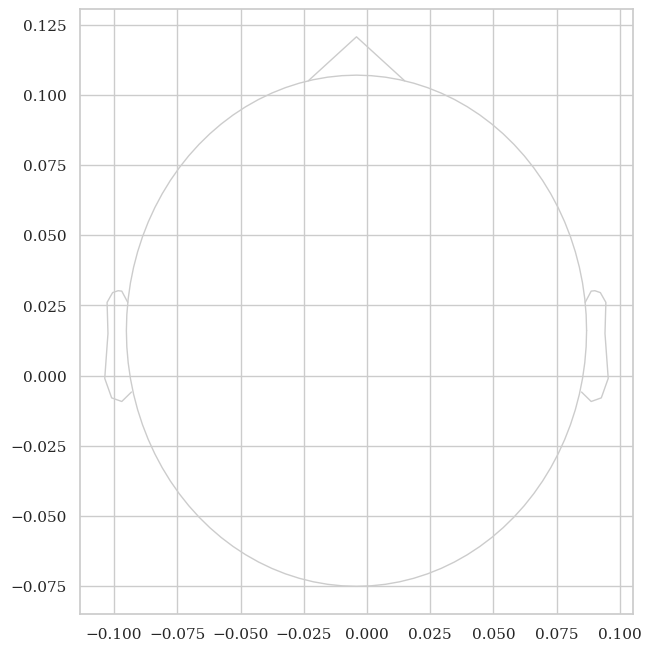

In [16]:
#show channel locations
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

Using matplotlib as 2D backend.


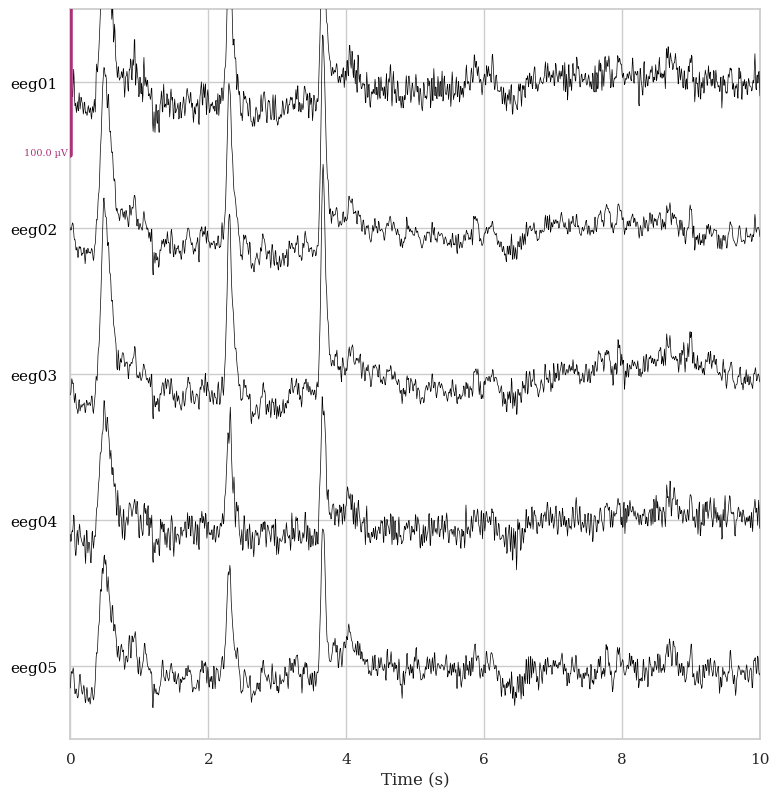

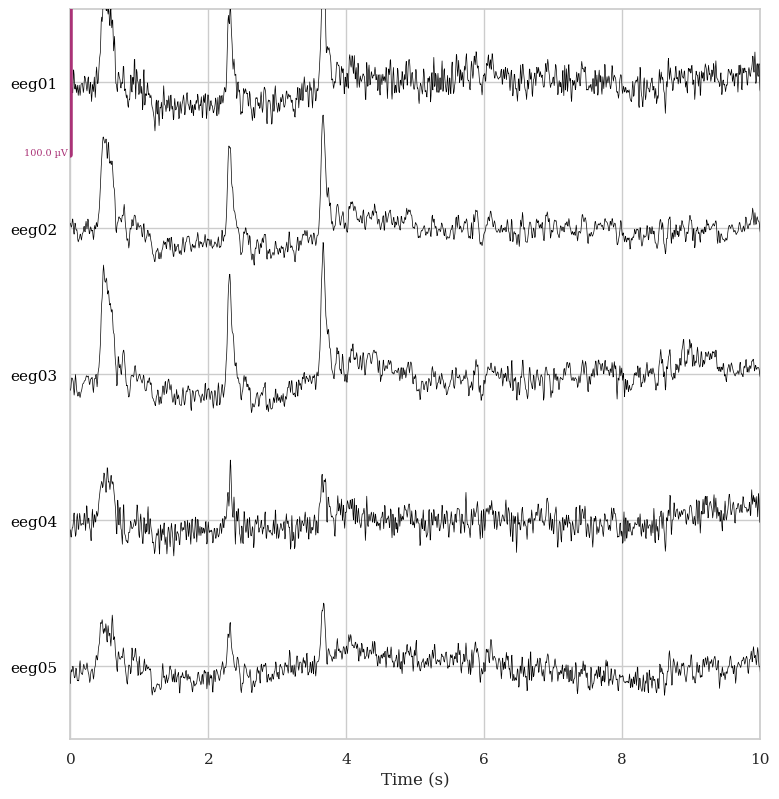

In [17]:
#see what it looked like before setting reference
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=False
        )
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

In [18]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MB, data loaded>

In [19]:
#events codes
np.unique(events[:, -1])

array([ 1,  2,  3,  4,  5, 32])

Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


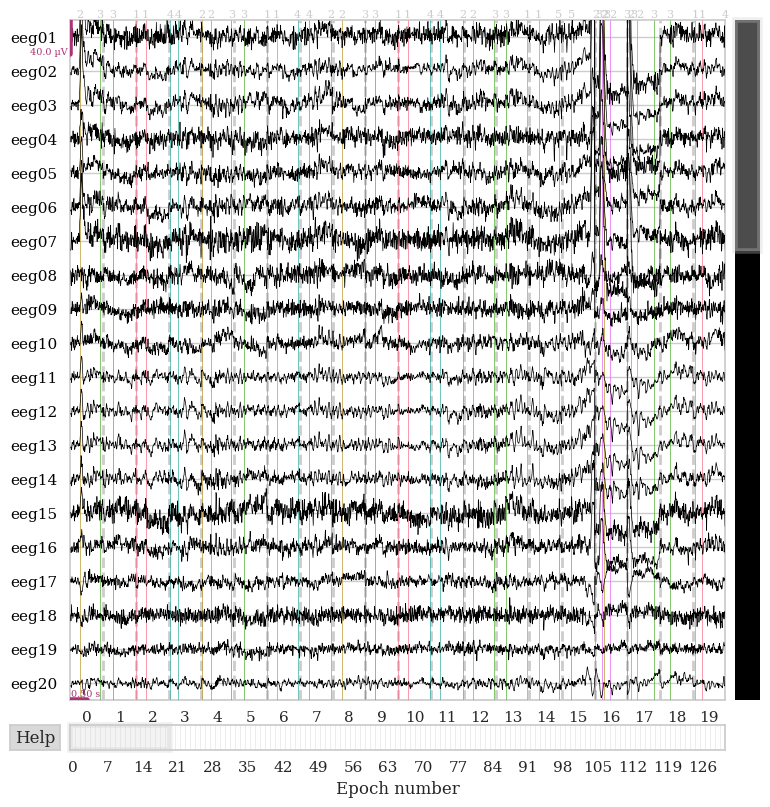

In [20]:
# rename events and construct epochs using intervals around each time event
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

In [21]:
#reject epochs if a channel amplitude exceeds max value
reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg25']
    Rejecting  epoch based on EEG : ['e

<Epochs | 114 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~11.0 MB, data loaded,
 'auditory/left': 25
 'auditory/right': 27
 'visual/left': 28
 'visual/right': 25
 'face': 5
 'buttonpress': 4>

In [22]:
epochs["auditory/left"]

<Epochs | 25 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~4.7 MB, data loaded,
 'auditory/left': 25>

In [23]:
epochs.get_data()

array([[[ 2.68832739e-06,  4.51833135e-07,  3.25235334e-06, ...,
          5.29717319e-06, -3.34375381e-06, -8.27555139e-06],
        [-2.69685461e-07,  8.12248321e-07,  2.79861850e-06, ...,
          4.16599840e-06,  3.49812587e-06,  1.25076392e-06],
        [-5.64064928e-07,  5.94194691e-06,  4.38947323e-06, ...,
         -5.22439980e-06, -1.24208873e-06, -5.57150253e-07],
        ...,
        [ 8.48906362e-06,  3.82585823e-06,  7.29229543e-07, ...,
         -4.85099632e-06, -7.06844647e-06, -6.52059909e-06],
        [ 9.03211005e-06,  2.18042621e-06, -1.98810853e-06, ...,
         -4.86898752e-07, -1.62795345e-06, -1.23584854e-06],
        [-1.89506035e-06, -6.01532852e-07, -4.23306123e-07, ...,
          1.37023794e-05,  7.83322521e-06,  3.17400407e-06]],

       [[ 1.31421704e-05,  3.52282835e-06, -8.48091679e-06, ...,
          1.29980787e-05,  6.50137294e-06, -2.21288656e-06],
        [ 4.52177009e-06,  9.65369963e-07, -2.06863397e-06, ...,
          2.26189591e-06, -2.97077105e

In [14]:
#get the evoked responses we care about by filtering events and averaging epochs
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

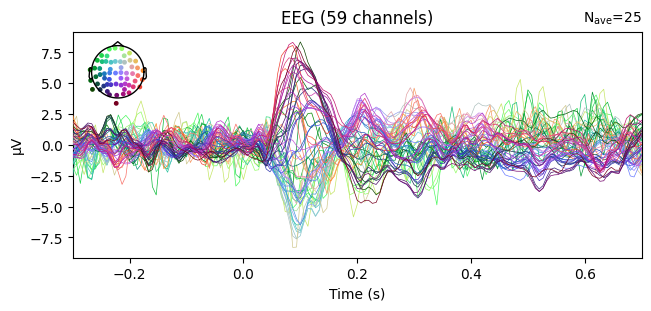

In [15]:
fig1 = l_aud.plot();
# fig2 = l_vis.plot(spatial_colors=True);

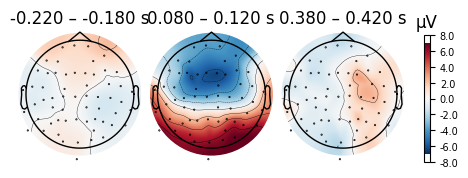

In [16]:
#display topomaps of the average evoked potential in 50 ms time windows centered at -200 ms, 100 ms, and 400 ms.
l_aud.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05);

Projections have already been applied. Setting proj attribute to True.


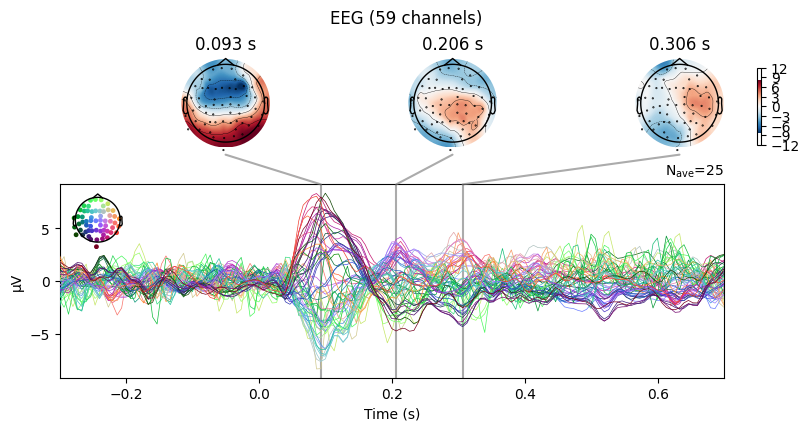

In [17]:
#see topomapson peak points together with butterflies plots 
l_aud.plot_joint();

In [18]:
def segment(ts, npeaks=3):
    '''
    define cut points of time series from its peaks and local minima values
    ToDo: exclude forbidden min and max values according to low ratio horizontal_dist/vertical_distance
    '''
    
    #minima
    min_idx = argrelextrema(ts, np.less)

    #peaks - choose 3 of them 
    max_idx = argrelextrema(ts, np.greater) #all peak candidates idx
    max_idx = np.argsort(ts)[np.isin(np.argsort(ts), max_idx)] #peaks idx sorted by ts value - the first one has the lowest ts value amongst the peak candidates 
    max_idx = max_idx[-npeaks:] #select how many peaks to consider 
    max_idx.sort() #sort by ascending index 

    #identify minima repair for each interval [begin,peak[ , [peak,peak[, [peak,end[
    min_repair_list = []
    cut_point_list = []
    id_left = 0
    for peak_id in max_idx:
        #locate local minima within peaks intervals - ""min_repair" is their mean value
        min_repair = (ts[id_left:peak_id][np.isin(np.arange(id_left,peak_id), min_idx)]).mean()
        min_repair_list.append(min_repair)

        #identify, for each peak value at the right, the closest minima id at its left that is less than minima repair
        #(cut at the time series index where its value at left of the peak is less than min_repair)
        cut_point = np.where(ts[id_left:peak_id]<=min_repair)[0][-1] + id_left #"+id_left" is to adjust the time series subinterval id to global time series id
        cut_point_list.append(cut_point)

        #iterate the pointer
        id_left = peak_id
        
    #last cut point should be defined at the right of the last peak
    min_repair = (ts[id_left:][np.isin(np.arange(id_left,len(ts)), min_idx)]).mean()
    cut_point = np.where(ts[id_left:]<=min_repair)[0][0] + id_left
    cut_point_list.append(cut_point)
    
    return max_idx, np.array(cut_point_list)

In [19]:
def img_idx_plot(cut_points, len_max, num_spatial_patterns = 4):
    '''
    define *num_spatial_patterns equally spaced points between cut_points of a time series of length=len_max
    '''
    #num_spatial_pattern is the number of spatial pattern plots per interval
    
    img_idx = [0]
    left_id = 0
    for cut_id in (list(cut_points)+[len_max-1]):
        img_idx_section = [int(np.floor((cut_id-left_id)*(i+1)/num_spatial_patterns)) + left_id for i in range(num_spatial_patterns)]
        img_idx = img_idx + img_idx_section
        left_id = cut_id
    
    img_idx = np.array(img_idx)
    return img_idx



In [20]:
l_aud.data.shape #num_channels,num_times_in_epoch

(60, 151)

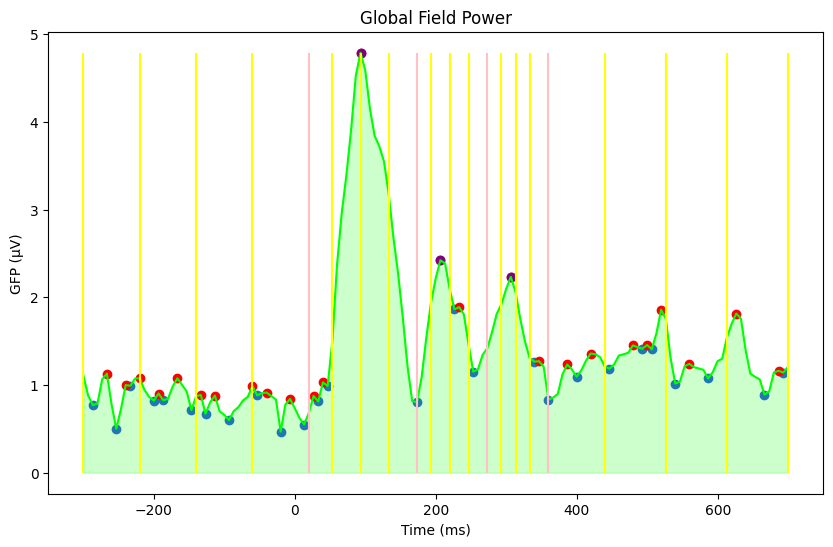

In [21]:
# Calculate Global Field Power and plot it with reference points
gfp = l_aud.data.std(axis=0) #this is the std, at each time step, for the ensemble of channels

min_idx = argrelextrema(gfp, np.less)
max_idx = argrelextrema(gfp, np.greater)

peak_idx, cut_points = segment(gfp, npeaks=3)

num_spat_pat = 4 #number of spatial patterns to plot (including cut point at right)
img_idx = img_idx_plot(cut_points, len(gfp), num_spat_pat)

# Visualize GFP
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(l_aud.times * 1000, gfp * 1e6, color="lime")
ax.fill_between(l_aud.times * 1000, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (ms)", ylabel="GFP (µV)", title="Global Field Power")
ax.scatter(l_aud.times[min_idx[0]]*1000, gfp[min_idx[0]]* 1e6, label="minima")
ax.scatter(l_aud.times[max_idx[0]]*1000, gfp[max_idx[0]]* 1e6, label="maxima", color = "r")
ax.scatter(l_aud.times[peak_idx]*1000, gfp[peak_idx]* 1e6, label="peaks", color = "purple")
ax.vlines(l_aud.times[img_idx]*1000,0, gfp.max()*1e6, label="img_idx", color = "yellow")
ax.vlines(l_aud.times[cut_points]*1000,0, gfp.max()*1e6, label="minima", color = "pink")

# ax.scatter(l_aud.times[min_repair]*1000, gfp[min_repair]* 1e6, label="minima", color = "pink")

There are 5 sections to be visualized (up to sec=4) - each section corresponds to the region between border and/or peaks.


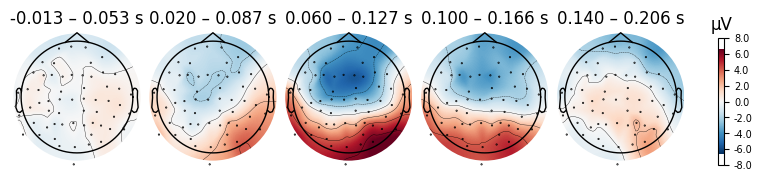

In [22]:
#display topomaps of the average evoked potential in 30 ms (average=0.03) time windows centered at the yellow and pink bars
print("There are {} sections to be visualized (up to sec={}) - each section corresponds to the region between border and/or peaks.".format(len(cut_points)+1,len(cut_points)))
sec_num = 1
spat_pat_times = l_aud.times[img_idx[sec_num*num_spat_pat:sec_num*num_spat_pat+num_spat_pat+1]]
window_duration = np.diff(spat_pat_times).mean()*2
l_aud.plot_topomap(times= spat_pat_times, average=window_duration); #space between each samples is of 6,668ms

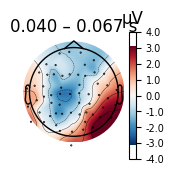

In [23]:
#plot using local scale
sec_num = 1
spat_pat_times = l_aud.times[img_idx[sec_num*num_spat_pat:sec_num*num_spat_pat+num_spat_pat+1]]

i = 1 #from 0 to num_spatial_patterns
l_aud.plot_topomap(times= spat_pat_times[i], average=0.03); #space between each samples is of 6,668ms

Projections have already been applied. Setting proj attribute to True.


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/mne/viz/evoked.py:235: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  axis.get_figure().canvas.draw()


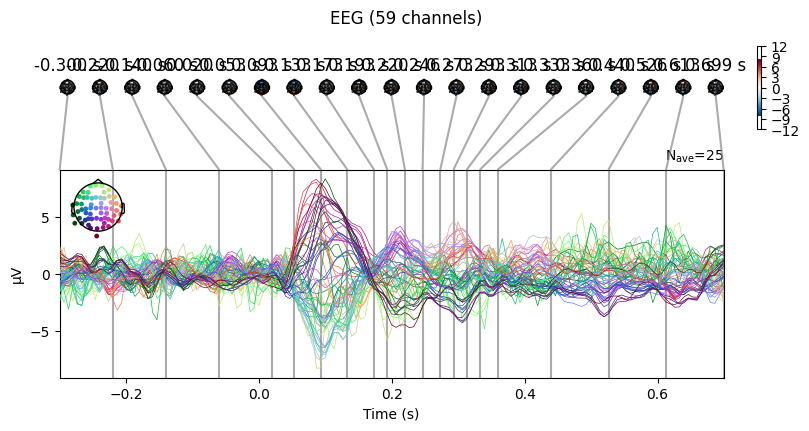

In [24]:
l_aud.plot_joint(times = l_aud.times[img_idx]);

In [25]:
l_aud_epochs = epochs["auditory/left"]
frms = field_root_mean_square(l_aud_epochs)

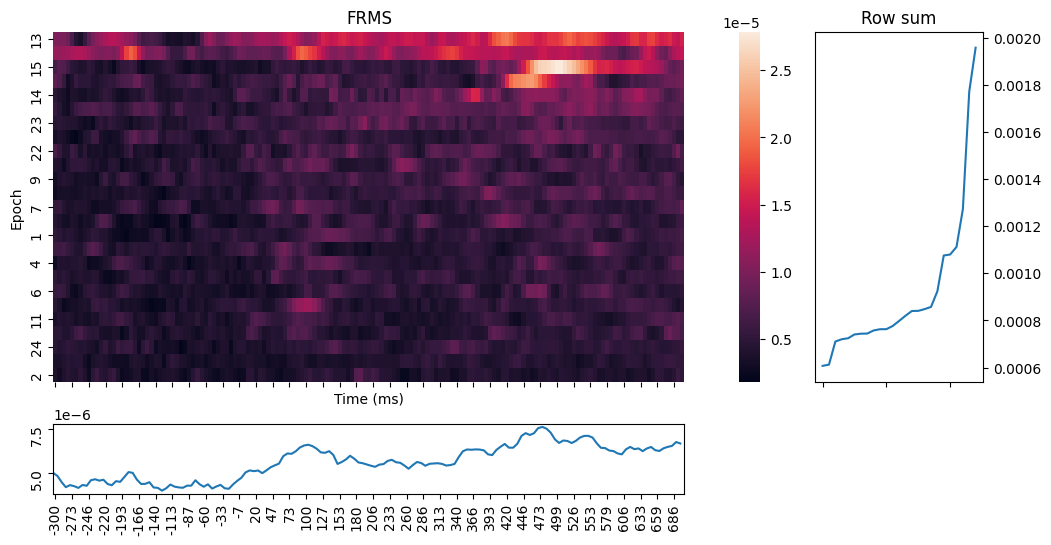

In [28]:
from power import plot_fmrs 
plot_fmrs(frms)

## Comparison between plot_epochs_image() from MNE and our plot_fmrs()

In [64]:
picks == np.arange(305)
picks
# # Extract the channel name and type
epochs.info['chs'][230]


{'scanno': 231,
 'logno': 2031,
 'kind': 1 (FIFFV_MEG_CH),
 'range': 1.0,
 'cal': 4.1400001482561066e-11,
 'coil_type': 3024 (FIFFV_COIL_VV_MAG_T3),
 'loc': array([ 1.68999992e-02, -9.71999988e-02,  3.97000015e-02, -3.00000014e-04,
        -3.72909993e-01, -9.27926004e-01,  9.90028024e-01,  1.30603999e-01,
        -5.28010018e-02,  1.40881002e-01, -9.18687999e-01,  3.69152009e-01]),
 'unit': 112 (FIFF_UNIT_T),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'MEG 2031',
 'coord_frame': 1 (FIFFV_COORD_DEVICE)}

Opening raw data file /nethome/costamai/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s


##################This is the femto Tesla amplitude of MEG channel number 230##################
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


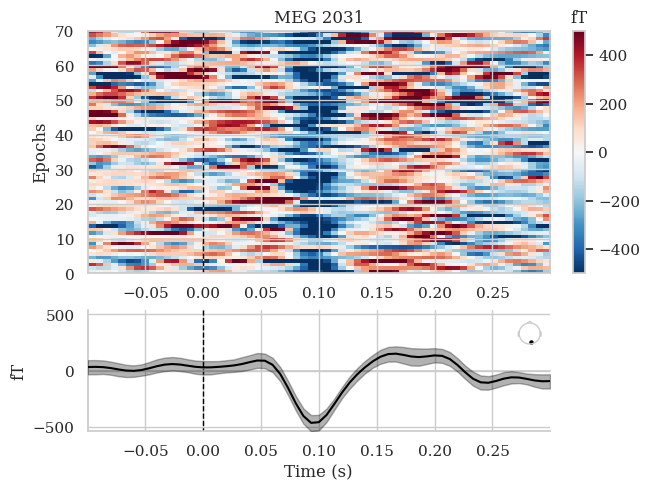

##################This is the field root mean square (takes into account all channels and it is referenced in common average)##################
<class 'mne.epochs.Epochs'>


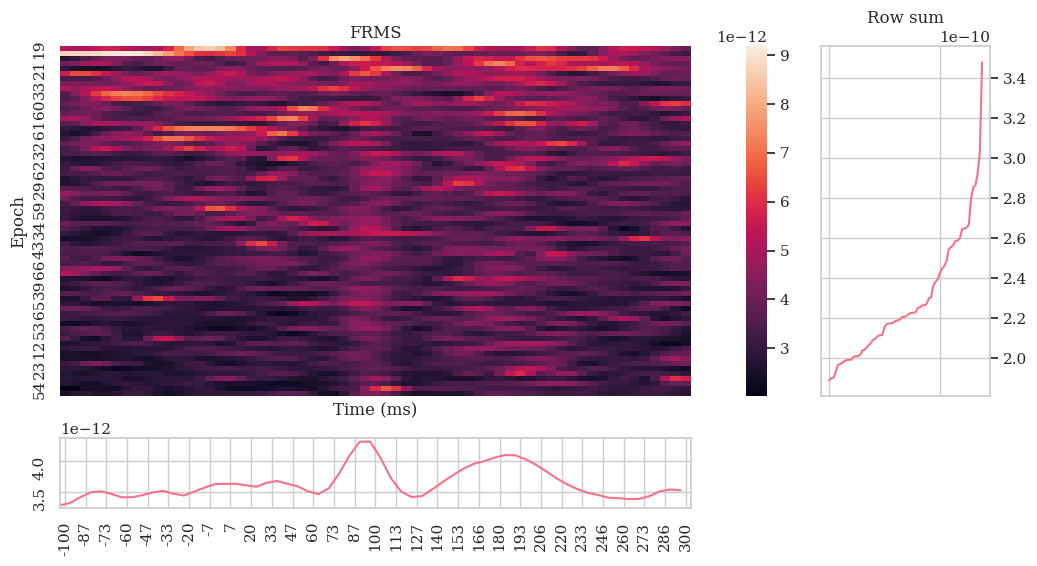

In [9]:
data_path = sample.data_path()

meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
event_fname = meg_path / "sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0.1, 0.3
event_id = dict(vis_r=4)

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 20, fir_design="firwin")  # replace baselining with high-pass
events = read_events(event_fname)

raw.info["bads"] = ["MEG 2443"]  # set bad channels
picks = pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False, exclude="bads")
# Epoching
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=False,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)



# Plot image epoch before xdawn
print("##################This is the femto Tesla amplitude of MEG channel number 230##################")
plot_epochs_image(epochs["vis_r"], picks=[230], vmin=-500, vmax=500);

print("##################This is the field root mean square (takes into account all channels and it is referenced in common average)##################")
plot_fmrs(field_root_mean_square(epochs["vis_r"]));

## XDAWN Denoising
XDAWN filters are trained from epochs, signal is projected in the sources space and then projected back in the sensor space using only the first two XDAWN components. The process is similar to an ICA, but is supervised in order to maximize the signal to signal + noise ratio of the evoked response

#### Warning 
As this denoising method exploits the known events to maximize SNR of the contrast between conditions it can lead to overfitting. To avoid a statistical analysis problem you should split epochs used in fit with the ones used in apply method.

In [41]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(raw, picks=picks)

# Xdawn instance
xd = Xdawn(n_components=2, signal_cov=signal_cov)

# Fit xdawn
xd.fit(epochs["vis_r"])

Using up to 1388 segments
Number of samples used : 41640
[done]
Estimating covariance using EMPIRICAL
Done.


Xdawn({'correct_overlap': 'auto',
 'n_components': 2,
 'reg': None,
 'signal_cov': <Covariance | kind : full, shape : (305, 305), range : [-2.1e-23, +6.6e-23], n_samples : 41639>})

Transforming to Xdawn space
Zeroing out 303 Xdawn components
Inverse transforming to sensor space
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


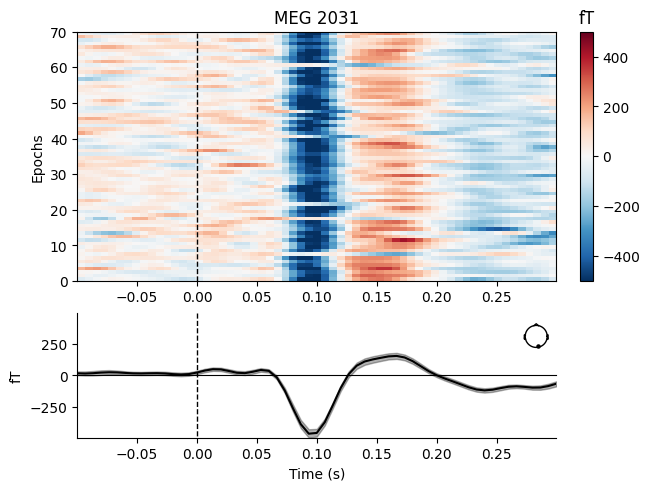

[<Figure size 640x480 with 4 Axes>]

In [42]:
epochs_denoised = xd.apply(epochs)

# Plot image epoch after Xdawn
plot_epochs_image(epochs_denoised["vis_r"], picks=[230], vmin=-500, vmax=500)

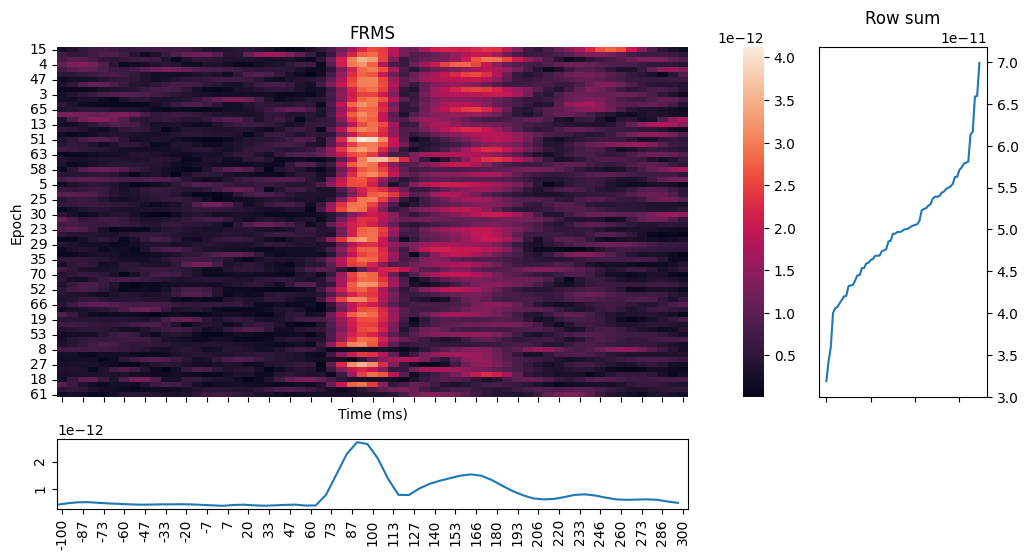

In [43]:
plot_fmrs(field_root_mean_square(epochs_denoised["vis_r"]))

### Spatial Filter
##### try the same, but using my spatial filter with 4 components


In [10]:
from data_processing import SpatialFilter

spatial_filter = SpatialFilter(epochs=epochs)
spatial_filter.fit(class_="vis_r")
filtered_epochs = spatial_filter.apply(epochs=epochs["vis_r"])

<class 'mne.epochs.Epochs'>


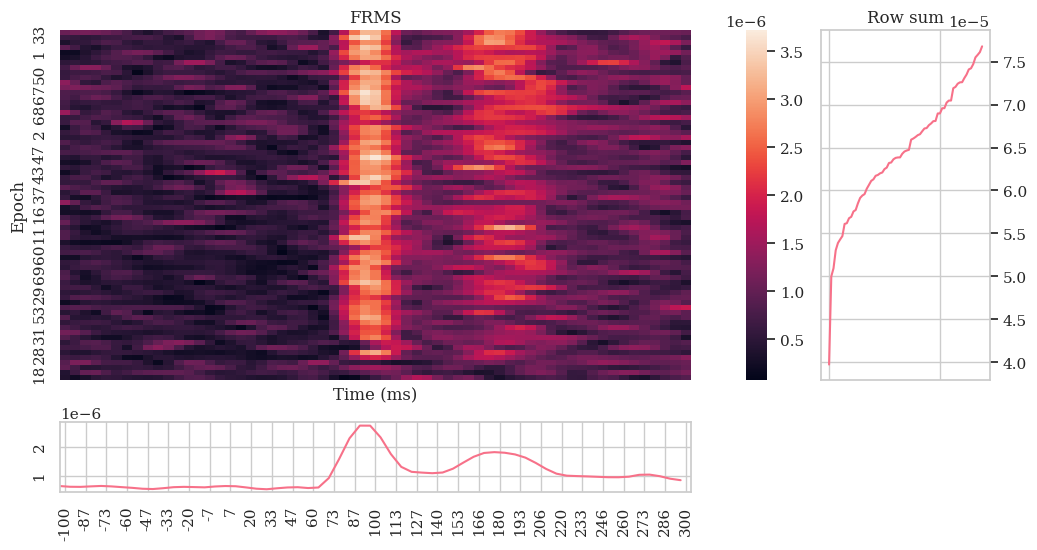

In [11]:
frms = field_root_mean_square(filtered_epochs)
plot_fmrs(frms)